# 基础概念
Moe是（Mixture of Experts），是一种使用许多不同的子模型（或“专家”）来提高LLM模型的能力。包含**Experts**和**Router**，其中Router负责选择将token送入哪些Experts。

## 存在的主要问题
* 负载均衡：专家选择不平衡


## 简化版MoE实现

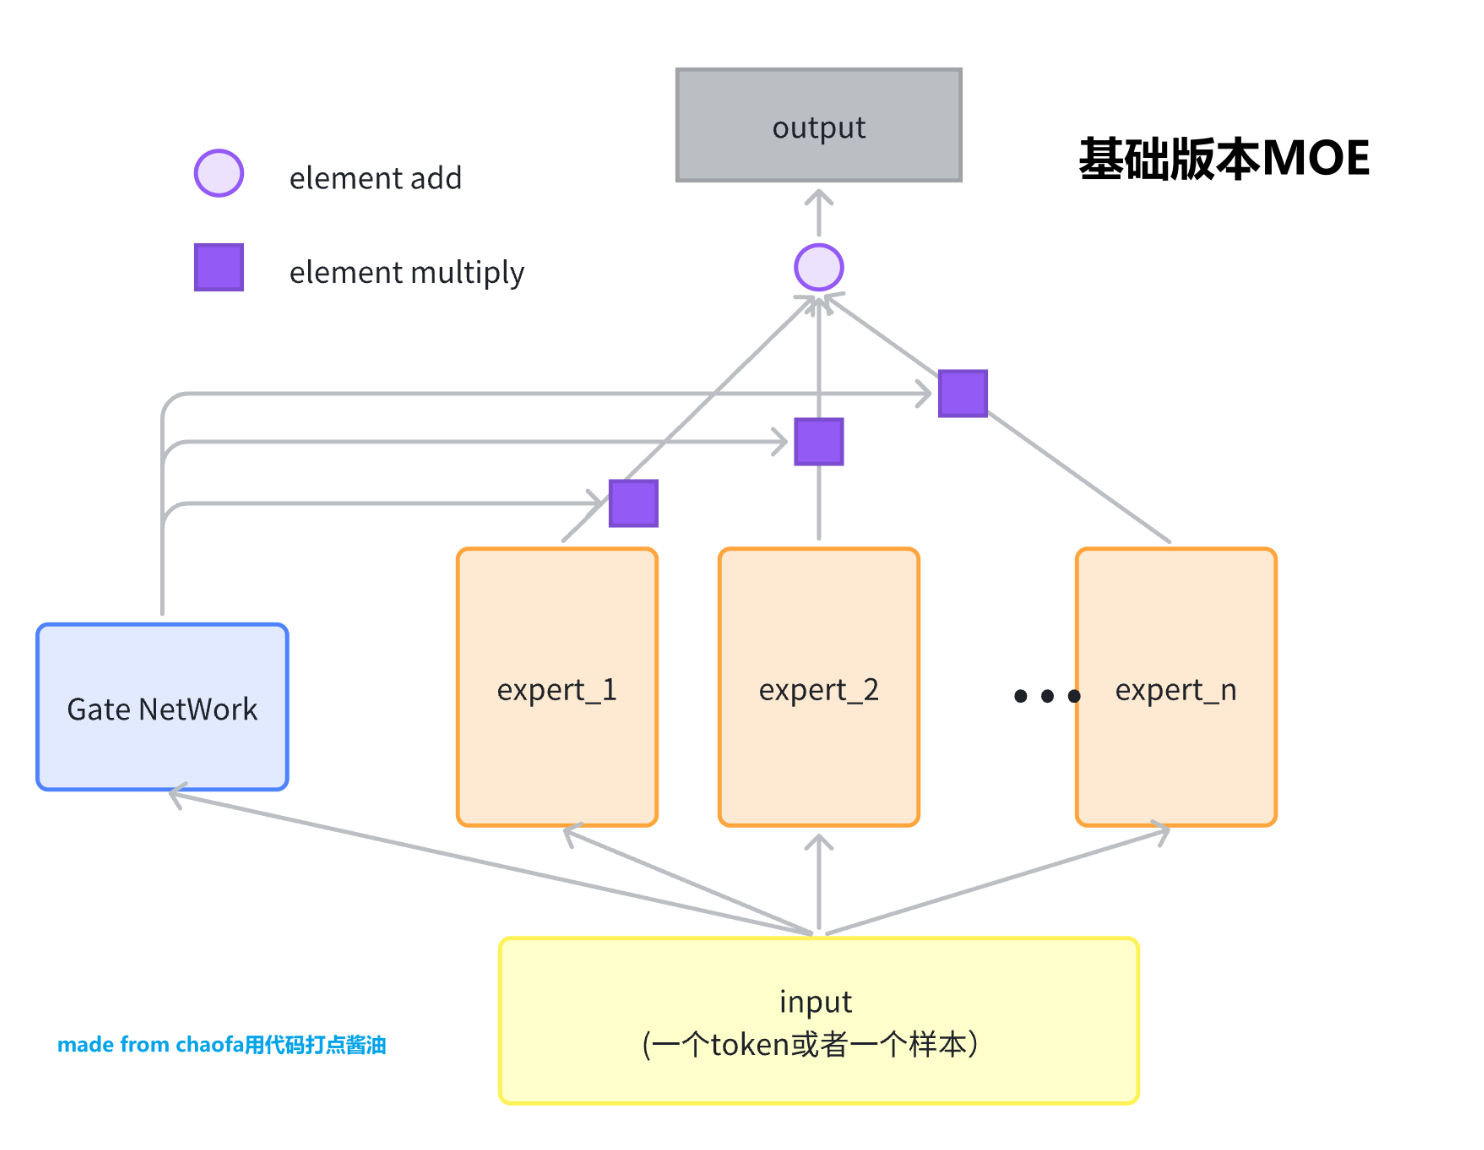

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

class BasicExpert(nn.Module):
    def __init__(self, feature_in, feature_out):
        super().__init__()
        self.linear = nn.Linear(feature_in, feature_out)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)
    
class BasicMOE(nn.Module):
    def __init__(self, nums_expert: int, feature_in: int, feature_out: int):
        super().__init__()
        self.experts = nn.ModuleList(
            BasicExpert(feature_in, feature_out) for _ in range(nums_expert)
        )
        self.nums_expert = nums_expert
        self.gate = nn.Linear(feature_in, nums_expert)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, hidden_dim = x.size()

        expert_weight = self.gate(x)

        experts_out_list = [
            self.experts[idx](x).unsqueeze(-2) for idx in range(self.nums_expert)
        ]

        expert_out = torch.cat(experts_out_list, dim=-2)
        expert_weight = expert_weight.unsqueeze(-2)

        output = expert_weight @ expert_out

        return output.squeeze()
    
def test_basic_moe():
    x = torch.rand(2,4,8)

    basic_moe = BasicMOE(4,8,8)
    out = basic_moe(x)
    print(out.size())

test_basic_moe()

torch.Size([2, 4, 8])


## 参考资料

[A Visual Guide to Mixture of Experts (MoE)](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mixture-of-experts "英文版MoE可视化介绍")
[LLM MOE的进化之路，从普通简化 MOE，到 sparse moe，再到 deepseek 使用的 share_expert sparse moe](https://bruceyuan.com/llms-zero-to-hero/the-way-of-moe-model-evolution.html "用代码打点酱油代码实现")